In [6]:
# Notes: For Emissions: "" and -- means missing
# For Energy_Use, "" is missing, For Energy_consumption -- means missing
# For Fossil_fuel_Energy both 0 and "" mean missing, can actually omit this and use renewable_energy instead (too much missing data)
#for GDP and Population -- means missing
# For Renewable_energy_cons "" means missing
# for Rents "" missing
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import missingno as mno
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split


In [7]:
# Load all data and keep only those whose ISO matches all the datasets
countries = pd.read_excel("./countries.xlsx")

def getData(file):
    '''
    Load all data and keep only those whose ISO matches all the datasets.
        file: name of file to be cleaned. Country names are cleaned of trailing spaces
    '''
    data = pd.read_csv(file, skiprows=1)
    
    data["Country"]=data["Country"].apply(lambda x: x.strip()) #strip trailing spaces
    data = data[data["Code"].isin(countries["Code"])] # check to see if it is in list
    data.reset_index(drop=True,inplace=True)
    
    return data

In [8]:
def clean_df(temp):
    '''
    Clean the dataframe of NaN, NA, empty spaces or -- and return it as a float
        temp: name of dataframe to be processed
    '''
    
    if 'Code' in temp.columns:
        temp = temp.drop(columns=['Country','Code'])
    
    temp = temp.replace('NaN', np.NaN)
    temp = temp.replace('NA', np.NaN)
    temp = temp.replace('', np.NaN)
    temp = temp.replace('--', np.NaN)
    
    temp = temp.transpose()
    return temp.astype(float)


In [9]:
#Process all files and add them to a list of dataframes for easy manipulation

df_list = []
df_names = []
for filename in os.listdir("data_processed/"):
    #print(filename)
    path = "data_processed/" + filename
    df_list.append(getData(path))
    df_names.append(filename)

for i in range(15):
    
    print( 'Missing values:', clean_df(df_list[i]).isnull().sum().sum(), '\t File name:', df_names[i])


#mno.matrix(df_list[8], figsize = (10, 3))

Missing values: 88 	 File name: Emissions_Coal.csv
Missing values: 0 	 File name: Emissions_GHG_(fromCAIT).csv
Missing values: 134 	 File name: Emissions_Natural_Gas.csv
Missing values: 218 	 File name: Emissions_Petroleum_other.csv
Missing values: 236 	 File name: Emissions_Total.csv
Missing values: 296 	 File name: Energy_Consumption_per_Capita.csv
Missing values: 296 	 File name: Energy_consumption_per_GDP.csv
Missing values: 1097 	 File name: Energy_use(kg-of-oil-equivalent-per-capita).csv
Missing values: 1134 	 File name: Fossil_fuel_energy_consumption(%_of_total).csv
Missing values: 99 	 File name: GDP.csv
Missing values: 89 	 File name: Population.csv
Missing values: 36 	 File name: Renewable_energy_consumption(%_of_total_final_energy_consumption).csv
Missing values: 140 	 File name: Rents_Coal.csv
Missing values: 120 	 File name: Rents_NaturalGas.csv
Missing values: 112 	 File name: Rents_Oil.csv


### KNN imputation

In [10]:
def KNNimpute(dataframe):
    '''
    Remove Country and Code columns, then scale the dataframe and then impute with the 3 nearest neighbors
    and then reinclude the Country and Code Columns.
        dataframe: dataframe whose values you need to impute using KNN
    '''
    temp = clean_df(dataframe).transpose()

    #Scale data
    scaler = MinMaxScaler()
    temp = scaler.fit_transform(temp)
    temp = temp.transpose()
    #impute
    imputer = KNNImputer(n_neighbors = 3)
    temp = pd.DataFrame(imputer.fit_transform(temp))
    
    #transpose and scale back, and add columns names and index back
    temp = temp.transpose()
    
    temp = pd.DataFrame(scaler.inverse_transform(temp))
    temp.insert(0,'c1',dataframe.Country)
    temp.insert(1,'c2',dataframe.Code)
    
    temp.columns = dataframe.columns
    return temp

### Inter/Extra-polation method with added noise

In [11]:
#randomly impute missing values by sampling from original 
# This method was not quite effective either
np.random.seed(42)
def random_imputation(df, df_imp, feature):
    '''
    Randomly impute missing values by sampling from original 
    However, this method was not quite effective either and needs to be ignored.
    '''
    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df_imp.loc[df[feature].isnull(), feature] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df_imp[feature]

## Linear Regression imputation and error estimation:

In [12]:
#Simple Linear Regression for imputing missing data
def LinReg_imp(dataframe):
    '''
    Check each country to see if they have missing data and impute based on the existing data points.
    Fit a linear regression model to predict the missing ones and add noise using the st dev of the rest of data points to not overfit.
        dataframe: dataframe with 167 countires and 30 years (1990-2020)
    '''
    df = clean_df(dataframe.copy())
    
    for feature in df.columns: # each country is the feature here
        if df[feature].isnull().sum() == 0: # skip if nothing to impute
            continue
        if all(df[feature].isnull()) == 1: # break if all values are NA cannot impute
            continue
        #train on available data, then predict missing data or the data we wanted to impute
        X = df[feature][df[feature].notnull()].index
        X = np.array(X).reshape(-1,1)
        y = df[feature][df[feature].notnull()]
        X = X.astype(float)
        y = y.astype(float)

        model = linear_model.LinearRegression()
        model.fit(X, y)

        y_missing = df[feature][df[feature].isnull()].index
        y_missing = np.array(y_missing).reshape(-1,1)
        y_predicted = model.predict(y_missing)

        #Standard Error of the regression estimates is equal to std() of the errors of each estimates
        stdev = np.std(y)
        df.loc[df[feature].isnull(),feature] = y_predicted + np.random.normal(0,1,  size = y_predicted.shape) * stdev

    temp = df.transpose()
    temp.reset_index(drop=True, inplace=True)
    temp.insert(0,'c1',dataframe.Country)
    temp.insert(1,'c2',dataframe.Code)
    temp.columns = dataframe.columns

    return temp


In [15]:
# Find the Error for this linear Regress
def LinReg_err(dataframe):
    '''
    Check each country to see if they have missing data and impute based on the existing data points. Split the given data in train/test.
    Fit a linear regression model to predict the test set and add noise using the st dev of the rest of data points to not overfit.
    Finally, calculate the mean absolute error to compare with other methods of imputation.
        dataframe: dataframe with 167 countires and 30 years (1990-2020)
    '''
    df = clean_df(dataframe.copy())
    total_error = []

    for feature in df.columns:
        if df[feature].isnull().sum() == 0: # skip if nothing to impute
            continue
        if all(df[feature].isnull()) == 1: # break if all values are NA cannot impute
            continue
        #train on available data, then predict missing data
        
        X = df[feature][df[feature].notnull()].index
        X = np.array(X).reshape(-1,1)
        y = df[feature][df[feature].notnull()]
        X = X.astype(float)
        y = y.astype(float)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        model = linear_model.LinearRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        #add std. dev as noise to predictions
        stdev = np.std(y)
        y_pred = np.abs(y_pred + np.random.normal(0,stdev,  size = y_pred.shape) * stdev)
        
        if all(y_test)==0:
            continue
            
        error = np.abs((y_test - y_pred)/y_test)
        
        total_error.append(error.sum())
    return np.sum(total_error),

## Polynomial Regression imputation and error estimation:

In [16]:
# USing n-th degree polynomial regression
def PolyReg_imp(dataframe, poly_degrees):
    '''
    Check each country to see if they have missing data and impute based on the existing data points.
    Fit a polynomial regression model to predict the missing ones and add noise using the st dev of the rest of data points to not overfit.
        dataframe: dataframe with 167 countires and 30 years (1990-2020)
    '''
    df = clean_df(dataframe.copy())

    for feature in df.columns:
        if df[feature].isnull().sum() == 0: # skip if nothing to impute
            continue
        if all(df[feature].isnull()) == 1: # break if all values are NA cannot impute
            continue  
        #train on available data, then predict missing data
        X = df[feature][df[feature].notnull()].index
        X = np.array(X).reshape(-1,1)
        y = df[feature][df[feature].notnull()]

        poly = PolynomialFeatures(degree = poly_degrees)
        X_poly = poly.fit_transform(X)

        poly.fit(X_poly, y)
        lin2 = linear_model.LinearRegression()
        lin2.fit(X_poly, y)


        y_missing = df[feature][df[feature].isnull()].index
        y_missing = np.array(y_missing).reshape(-1,1)

        X_polytest = poly.fit_transform(y_missing)
        y_pred = lin2.predict(X_polytest)
        #Standard Error of the regression estimates is equal to std() of the errors of each estimates
        stdev = np.std(y)
        y_pred = np.abs(y_pred + np.random.normal(0,stdev,  size = y_pred.shape) * stdev)
        df.loc[df[feature].isnull(),feature] = y_pred
    
    temp = df.transpose()
    temp.reset_index(drop=True, inplace=True)
    temp.insert(0,'c1',dataframe.Country)
    temp.insert(1,'c2',dataframe.Code)
    temp.columns = dataframe.columns

    return temp


In [17]:
#np.random.seed(10)
def PolyReg_err(dataframe, poly_degrees):
    '''
    Check each country to see if they have missing data and impute based on the existing data points. Split the given data in train/test.
    Fit a polynomial regression model to predict the test set and add noise using the st dev of the rest of data points to not overfit.
    Finally, calculate the mean absolute error to compare with other methods of imputation.
        dataframe: dataframe with 167 countires and 30 years (1990-2020)
    '''
    df = clean_df(dataframe.copy())
    total_error = []

    for feature in df.columns:
        if df[feature].isnull().sum() == 0: # skip if nothing to impute
            continue
        if all(df[feature].isnull()) == 1: # break if all values are NA cannot impute
            continue
            
        #train on available data, then predict missing data
        X = df[feature][df[feature].notnull()].index
        X = np.array(X).reshape(-1,1)
        y = df[feature][df[feature].notnull()]
        X = X.astype(float)
        y = y.astype(float)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        poly = PolynomialFeatures(degree = poly_degrees)
        X_poly = poly.fit_transform(X_train)

        poly.fit(X_poly, y_train)
        lin2 = linear_model.LinearRegression()
        lin2.fit(X_poly, y_train)

        X_polytest = poly.fit_transform(X_test)
        y_pred = lin2.predict(X_polytest)

        #add std. dev as noise to predictions
        stdev = np.std(y)
        y_pred = np.abs(y_pred + np.random.normal(0,stdev,  size = y_pred.shape) * stdev)
        
        if all(y_test)==0:
            continue
        error = np.abs((y_test - y_pred)/y_test)
        
        total_error.append(error.sum())
    return np.sum( total_error)

# Combining KNN and PolyReg for optimal imputation

In [18]:

def KNN_and_PolyReg(dataframe):
    '''
    First we comb through the dataframe and find the countries with more than half (15+) years of missing data. For these we use Knn Imputation. For the rest PolyReg 3rd degree will work best.
        dataframe: dataframe with 167 countires and 30 years (1990-2020)
    '''
    dataframe = df_list[0]
    df_knn = clean_df(dataframe).transpose()
    knnimp = df_knn.isna().sum(axis=1) >= 7  # find which countries have more than 8 years of NaN

    #impute for the whole dataframe but keep only those with more than 7 years of NAN
    df = KNNimpute(dataframe)

    #Now just do PolyReg
    df_poly = PolyReg_imp(dataframe, 3)

    df_poly[knnimp] = df[knnimp]
    return df_poly
#data.iloc[99]

## Visualizing the errors from PolyReg and LinReg

In [19]:
df_err = pd.DataFrame(index=df_names, columns = ['LinReg', 'PolyReg2'])

df_err['LinReg'] = [LinReg_err(df_list[i]) for i in range(len(df_list))]
df_err['PolyReg2'] = [PolyReg_err(df_list[i], 2) for i in range(len(df_list))]
df_err['PolyReg3'] = [PolyReg_err(df_list[i], 3) for i in range(len(df_list))]
df_err['PolyReg3_KNN'] = [PolyReg_err(df_list[i], 3) for i in range(len(df_list))]

df_err = df_err.drop(index=['Population.csv','GDP.csv'])



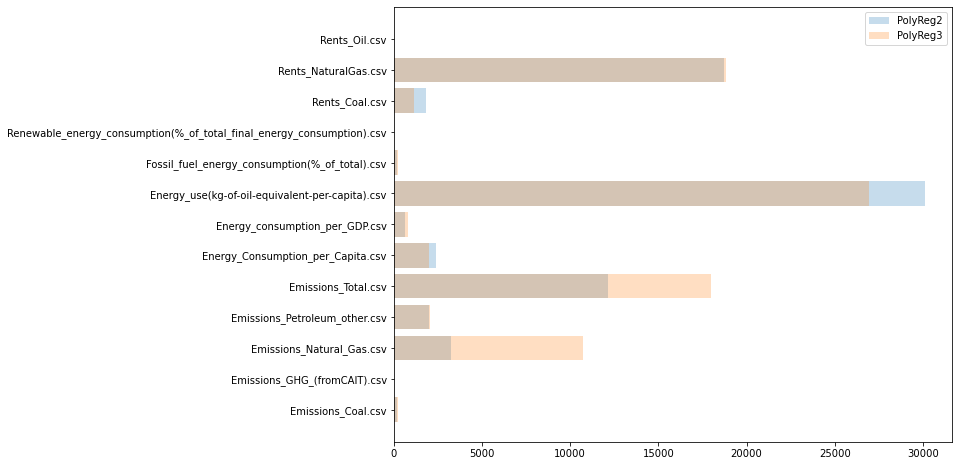

In [20]:
fig = plt.figure(figsize=(10, 8))
[#plt.barh(df_err.index, df_err['LinReg'], alpha = 0.5,align='edge', label='LinReg'), 
plt.barh(df_err.index, df_err['PolyReg2'], alpha = 0.25, label='PolyReg2'), 
plt.barh(df_err.index, df_err['PolyReg3'], alpha = 0.25, label='PolyReg3')]
plt.legend()

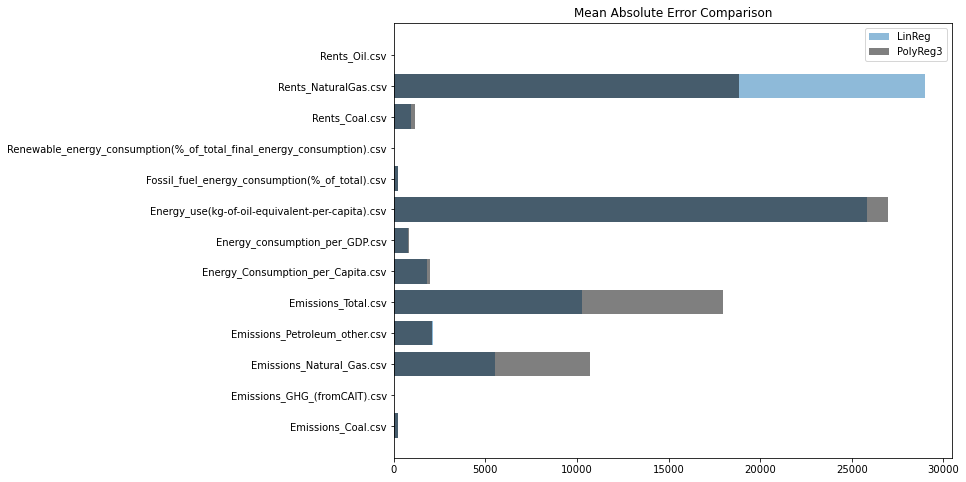

In [21]:
fig = plt.figure(figsize=(10, 8))
[plt.barh(df_err.index, df_err['LinReg'], alpha = 0.5, label='LinReg'), 
#plt.barh(df_err.index, df_err['PolyReg2'], alpha = 0.5, label='PolyReg2'), 
plt.barh(df_err.index, df_err['PolyReg3'], alpha = 0.5, label='PolyReg3', color = 'black')]
plt.title('Mean Absolute Error Comparison')
plt.legend()

### Saving files

In [22]:
# save csv in file
#path = r"C:\Users\fabio\Documents\GitHub\EIB2_ClimateRisk\cleaned data\data_imputed\imputed_knn"

#for i in range(len(df_list)):
    #KNNimpute(df_list[i]).to_csv(path +"/" + df_names[i])

In [23]:
'''
for i in range(len(df_list)):
    PolyReg_imp(df_list[i],3).to_csv(df_names[i])
    
for i in range(len(df_list)):
    KNNimpute(df_list[i]).to_csv(df_names[i])
'''

### Missing data profile

<BarContainer object of 15 artists>

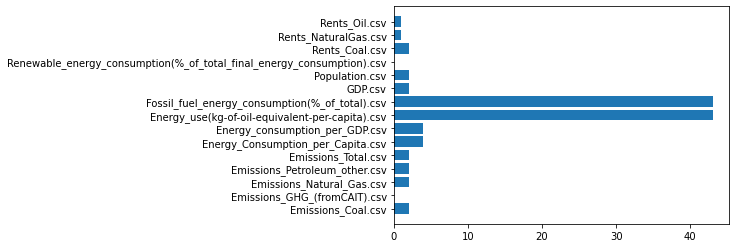

In [27]:
# missing data profile for one of the dataframes (df_list[1])
df_missing_ct = pd.DataFrame(columns=df_names, index = df_list[1].columns)

for i in range(len(df_list)):
    count = 0
    df = clean_df(df_list[i])
    for j in df.columns:
        if df[j].isnull().sum() >14:
            #print('in df',df_names[i] ,'A country has: ',df[j].isnull().sum(), 'missing values')
            count += 1
    df_missing_ct[df_names[i]] = count
df_missing_ct
plt.barh(df_missing_ct.columns, df_missing_ct.max())

<ipython-input-28-4fc91b67ed08>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


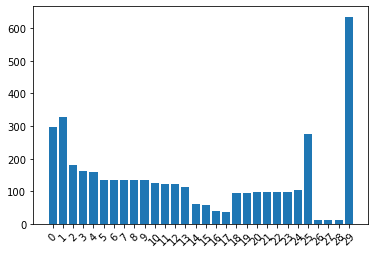

In [28]:
# Review which years have the most missing data. it seems year 0 and 29 which correspond to 1990 and 2020 have the most missing as expected
df_missing = pd.DataFrame(columns=df_names)
for i in range(len(df_list)):
    df = clean_df(df_list[i]).transpose()
    for j in df.columns:
        if df[j].isnull().sum() >3:
                #print('in df',df_names[i] ,'in year',j ,' has: ',df[j].isnull().sum(), 'missing values')
                df_missing[df_names[i]] = df.isnull().sum()

df_missing.transpose().sum().shape,df_missing.transpose().columns
plt.bar(df_missing.transpose().columns, df_missing.transpose().sum())
ax = plt.gca()
ax.set_xticklabels(ax.get_xticks(), rotation = 45)
plt.show()

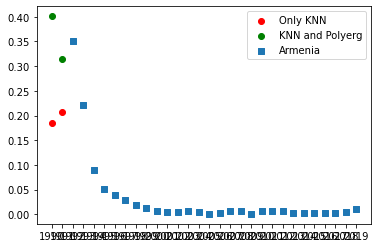

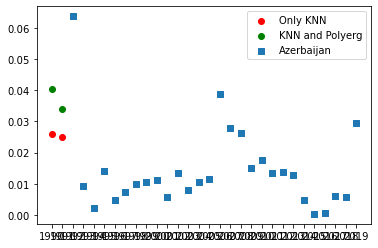

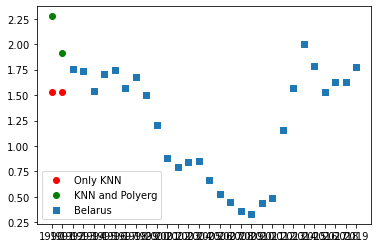

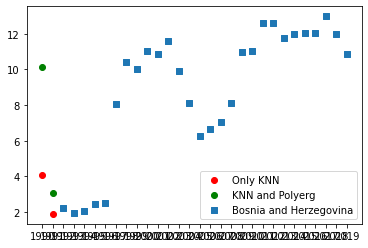

In [29]:
#Review how the different imputations fit
df2 = clean_df(df_list[0]).transpose()
df3 = clean_df(KNNimpute(df_list[0])).transpose()
df4 = clean_df(KNN_and_PolyReg(df_list[0])).transpose()

for i in [5,8,12,18]:
    
    plt.scatter(np.array(df3.iloc[i].index), np.array(df3.iloc[i].values), label = 'Only KNN', color = 'red')
    plt.scatter(np.array(df4.iloc[i].index), np.array(df4.iloc[i].values), label = 'KNN and Polyerg', color = 'green')
    plt.scatter(np.array(df2.iloc[i].index), np.array(df2.iloc[i].values), label = df_list[0].iloc[i,0], marker = 's')
    plt.legend()
    plt.show()

    # review marcro trends, Eastern bloc, Oil, GDP expansions